# Comparison of Rome and Oslo

## Introduction
#### Background
My idea is to compare the capitals of two different countries in Europe, that is Italy and Norway. Since the climate and temperature are different, I wonder what kind of venues or kind of business can you find in Oslo and Rome. Do people living in western countries have different ways of spending time than in the colder North? What kind of business is the most profitable in these places? We will be able to see how much residents' needs differ depending on the location.

#### Target Audience
This project may be interesting for those, who have money and an idea of some kind of business, but are not sure, where should they start it.

## Data
A list of Oslo's and Rome's districts will be scraped with BeautifulSoup library off the Wikipedia website. After that, I'm going to use Geocoder to look for the coordinates and Foursquare API to get more details about the venues. So, in the end, the data will consist of such details as:
- District's name
- Neighbourhood
- Business name (for example store name)
- Business category
- Longitude
- Latitude

**FOR THE NOTEBOOKS READABILITY, I'VE PLACED THE FUNCTIONS IN SEPARATE FILE CALLED `FUNCS.PY`**

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as soup
import requests
from funcs import *
import os
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Scrap off Wikipedia a list of Rome Municipios' number, their names and neighbourhoods they consist of.

Make a dataframe out of it.

## Scrap Data Off Wikipedia

In [2]:
link = "https://en.wikipedia.org/wiki/Administrative_subdivision_of_Rome"
page = requests.get(link)
page = soup(page.content, 'html.parser')

In [3]:
municip = []

tables = page.findAll("table")[1].findAll("tr")[1:]
for tabrow in tables:
    tabrow = tabrow.findAll("td")[0].text.replace("\n", "").split(" – ")
    municipio = tabrow[0].split(" ")[1]
    name = tabrow[1]
    municip.append([municipio, name])
    
municip_df = pd.DataFrame(municip, columns=["Municipio", "Borough"])
municip_df

,Municipio,Borough
0,I,Historical Center
1,II,Parioli/Nomentano
2,III,Monte Sacro
3,IV,Tiburtina
4,V,Prenestino/Centocelle
5,VI,Roma Delle Torri
6,VII,Appio-Latino/Tuscolano/Cinecittà
7,VIII,Appia Antica
8,IX,EUR
9,X,Ostia/Acilia


In [4]:
subdivisions = page.findAll("ul")[3].findAll("li")

italian_subdivs = []
for subdiv in subdivisions:
    subdiv = subdiv.text.split(": ")
    municipio = subdiv[0].split(" ")[1]
    divs = subdiv[1].split(", ")
    divs = [dv.replace(";", "")[3:] for dv in divs]
    for dv in divs:
        if dv[0] == " ":
            dv = dv[1:]
        if "[it]" in dv:
            dv = dv[:-8]
        italian_subdivs.append([municipio, dv])
italy_df = pd.DataFrame(italian_subdivs, columns =["Municipio", "Neighborhood"])
italy_df

,Municipio,Neighborhood
0,I,Historic centre
1,I,Trastevere
2,I,Aventino
3,I,Testaccio
4,I,Esquilino
...,...,...
150,XV,Prima Porta
151,XV,Labaro
152,XV,Cesano
153,XV,Martignano


In [5]:
italy_df = pd.merge(municip_df, italy_df, on="Municipio")
italy_df.drop(["Municipio"], axis=1, inplace=True)
italy_df

,Borough,Neighborhood
0,Historical Center,Historic centre
1,Historical Center,Trastevere
2,Historical Center,Aventino
3,Historical Center,Testaccio
4,Historical Center,Esquilino
...,...,...
150,Cassia/Flaminia,Prima Porta
151,Cassia/Flaminia,Labaro
152,Cassia/Flaminia,Cesano
153,Cassia/Flaminia,Martignano


Scrap off Wikipedia a list of Oslo boroughs and neighbourhoods they consist of.

Clean data and make a dataframe out of it.

In [6]:
link = "https://en.wikipedia.org/wiki/List_of_boroughs_of_Oslo"
page = requests.get(link)
page = soup(page.content, 'html.parser')

Depending on the article, informations about neighborhoods are located in different places - sometimes it's first list, sometimes second and sometimes the information is in between words. For the last case, I've made a dictionary with neighborhoods for a specific borough.

In [7]:
first = ["Alna", "Bjerke", "Gamle Oslo", "Nordstrand", "Søndre Nordstrand", "Vestre Aker"]
second = ["Frogner"]

other = {
    "Sagene":["Sagene", "Bjølsen", "Iladalen (Ila)", "Sandaker", "Åsen", "Torshov"],
     "St. Hanshaugen":["St. Hanshaugen"],
     "Stovner":["Stovner"],
     "Ullern":["Lysejordet", "Øraker", "Lilleaker", "Sollerud", "Vækerø", "Bestum", "Ullern", 
     "Bjørnsletta", "Ullernåsen", "Montebello", "Hoff", "Skøyen"],
     "Østensjø":["Bøler", "Oppsal" , "Manglerud"],
     "Grünerløkka":["Grünerløkka"],
     "Grorud":["Grorud", "Ammerud", "Grorud", "Kalbakken", "Rødtvet", "Nordtvet", "Romsås"],
    "Nordre Aker":["Gaustad", "Øvre Blindern", "Ullevål Hageby", "Sogn", "Kringsjå", "Nordberg", "Korsvoll", "Tåsen", 
    "Ullevål", "Berg", "Nydalen", "Storo", "Frysja", "Disen", "Kjelsås", "Grefsen", "Nordre Åsen"]
     }

Function to which scrapes data off particular <"ul"> element on the site. Articles are different and these informations may be in first or second list.

In [8]:
def open_link_and_get_districts(link, order):
    page = requests.get(link)
    page = soup(page.content, 'html.parser')
    districts = page.findAll("ul")[order-1].findAll("li")
    districts = [d.text.replace("\n", "") for d in districts]
    return districts

In [9]:
wiki_link = "https://en.wikipedia.org/"

oslo_subdivs = []
tab = page.find("table", {"class":"wikitable"}).findAll("tr")[1:]
for i in tab:
    borough = i.find("td").text
    neigh_link = i.find("td").a["href"]
    if borough in first:
        districts = open_link_and_get_districts(wiki_link + neigh_link, 1)
    elif borough in second:
        districts = open_link_and_get_districts(wiki_link + neigh_link, 2)
    if borough in list(other.keys()):
        districts = other[borough]
    for dv in districts:
        oslo_subdivs.append([borough, dv])
oslo_df = pd.DataFrame(oslo_subdivs, columns =["Borough", "Neighborhood"])
oslo_df

,Borough,Neighborhood
0,Alna,Alnabru
1,Alna,Ellingsrud
2,Alna,Furuset
3,Alna,Haugerud
4,Alna,Hellerud
...,...,...
91,Vestre Aker,Sørkedalen
92,Vestre Aker,"Smestad, Oslo"
93,Østensjø,Bøler
94,Østensjø,Oppsal


Some neighbourhoods have additional comments in their naming, so shorten it.

In [10]:
oslo_df["Neighborhood"][oslo_df["Neighborhood"].str.contains("Lofthus")] = "Lofthus"
oslo_df["Neighborhood"][oslo_df["Neighborhood"].str.contains("Iladalen")] = "Iladalen"
oslo_df["Neighborhood"][oslo_df["Neighborhood"].str.contains("Holmenkollen")] = "Holmenkollen"

In [11]:
from opencage.geocoder import OpenCageGeocode

Get the credentials written in separated .txt file for the safety.

In [12]:
with open("creds.txt", "r") as f:
    creds = f.read()
creds = creds.split("\n")
CLIENT_ID = creds[0]
CLIENT_SECRET = creds[1]
KEY2 = creds[2]

## OpenCage GeoCoder
### Oslo, NORWAY
Retrieve coords of the neighborhoods with OpenCage GeoCoder API.

In [13]:
geocoder = OpenCageGeocode(KEY2)
if os.path.isfile("csv/oslo_lon_lan.csv"):
    oslo_df = pd.read_csv("csv/oslo_lon_lan.csv")
else:
    latitudes, longitudes = [], []

    for i, row in oslo_df.iterrows():
        neigh = row[-1]
        query = f"{neigh}, Norway"
        results = geocoder.geocode(query)
        lat = results[0]['geometry']['lat']
        lng = results[0]['geometry']['lng']
        latitudes.append(lat)
        longitudes.append(lng)

    oslo_df["Latitude"] = latitudes
    oslo_df["Longitude"] = longitudes
oslo_df

,Borough,Neighborhood,Latitude,Longitude
0,Alna,Alnabru,59.926682,10.836498
1,Alna,Ellingsrud,59.934191,10.920897
2,Alna,Furuset,59.941067,10.896399
3,Alna,Haugerud,59.922116,10.854522
4,Alna,Hellerud,59.910067,10.829839
...,...,...,...,...
78,Vestre Aker,Tryvann,59.986706,10.666887
79,Vestre Aker,Vinderen,59.942802,10.704988
80,Vestre Aker,"Smestad, Oslo",59.937212,10.684161
81,Østensjø,Bøler,59.884271,10.845545


Data cleaning because some of the coords are mismatched.

In [14]:
to_get_rid_of = ["Ekeberg", "Sørkedalen", "Nordre Åsen", "Klemetsrud", "Sandaker", "Lofthus", "Disen",
                "Nordberg", "Åsen", "Røa", "Iladalen", "Oppsal", "Sogn"]
oslo_df = oslo_df[~oslo_df.Neighborhood.isin(to_get_rid_of)].reset_index(drop=True)

Make a visualisation of Oslo's neighborhoods with Folium library.

In [15]:
import folium
OSLO_COORDS = [59.91273, 10.74609]
map_oslo = folium.Map(location=OSLO_COORDS,zoom_start=11)

for i, row in oslo_df.iterrows():
    lat = float(row[-2])
    lng = float(row[-1])
    label = row[1]
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo) 
map_oslo

Show the bar chart of neighborhoods in Oslo boroughs.

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

sns.set(font_scale=1.5)
rcParams["figure.figsize"] = (26, 8)

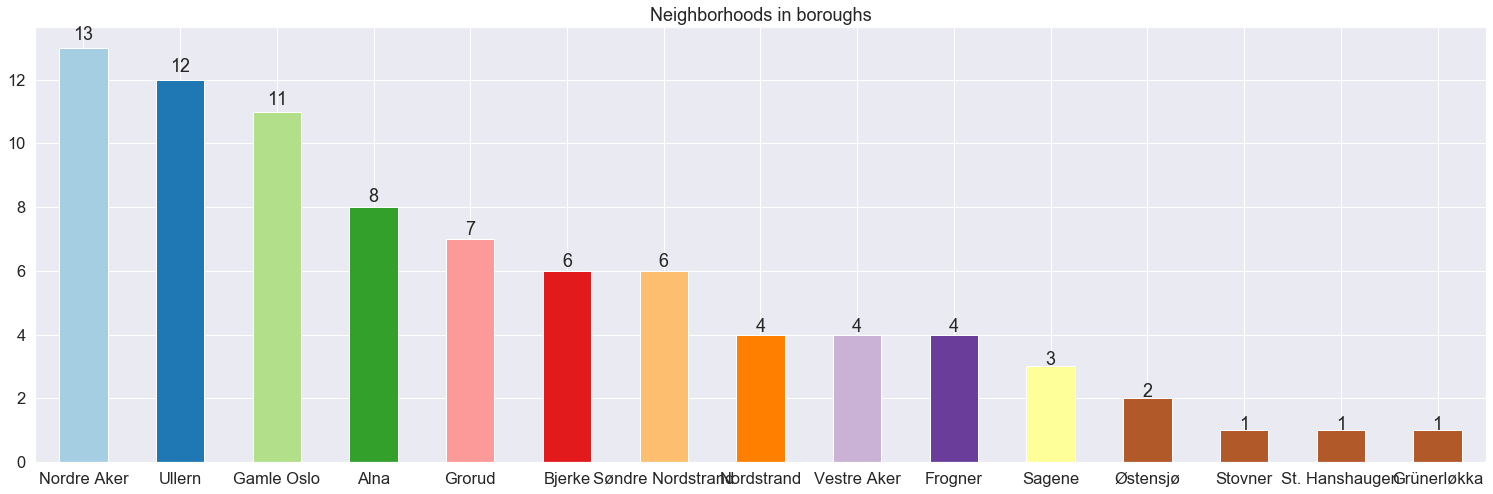

In [17]:
df_temp = oslo_df.Borough.value_counts().to_frame()
bars = df_temp.plot(kind="bar", rot=0, legend=False,
                    title="Neighborhoods in boroughs",
                    color=[plt.cm.Paired(np.arange(len(df_temp)))])

for bar in bars.patches:
    width, height = bar.get_width(), bar.get_height()
    x, y = bar.get_xy() 
    bars.annotate(height, (x + width/2, y + height*1.02), ha='center')

Save the retrieved data to csv file, so you don't have to use the API everytime you run the notebook.

In [18]:
if not os.path.isfile("csv/oslo_lon_lan.csv"):
    oslo_df.to_csv("csv/oslo_lon_lan.csv", index=False)

## OpenCage GeoCoder
### Rome, ITALY
Retrieve coords of Rome's neighborhoods with OpenCage GeoCoder API.

In [19]:
if os.path.isfile("csv/rome_lon_lan.csv"):
    italy_df = pd.read_csv("csv/rome_lon_lan.csv")
else:
    latitudes, longitudes = [], []

    for i, row in italy_df.iterrows():
        neigh = row[-1]
        query = f"{neigh}, Italy"
        results = geocoder.geocode(query)
        lat = results[0]['geometry']['lat']
        lng = results[0]['geometry']['lng']
        latitudes.append(lat)
        longitudes.append(lng)
    italy_df["Latitude"] = latitudes
    italy_df["Longitude"] = longitudes
    
italy_df

,Borough,Neighborhood,Latitude,Longitude
0,Historical Center,Trastevere,41.883765,12.471270
1,Historical Center,Aventino,41.882825,12.486819
2,Historical Center,Esquilino,41.898044,12.498863
3,Historical Center,XX Settembre,41.906151,12.496895
4,Parioli/Nomentano,Villaggio Olimpico,41.932966,12.474157
...,...,...,...,...
99,Cassia/Flaminia,Santa Cornelia,42.029061,12.451673
100,Cassia/Flaminia,Prima Porta,42.001975,12.485970
101,Cassia/Flaminia,Labaro,41.990222,12.489245
102,Cassia/Flaminia,Cesano,42.077635,12.341911


Data cleaning because some of the coords are mismatched.

In [20]:
italy_df = italy_df[italy_df.Latitude < 42.721312].reset_index(drop=True)
italy_df = italy_df[italy_df.Latitude > 41.640312].reset_index(drop=True)
italy_df = italy_df[italy_df.Longitude < 13.155438].reset_index(drop=True)
italy_df = italy_df[italy_df.Longitude > 11.438524].reset_index(drop=True)
italy_df

,Borough,Neighborhood,Latitude,Longitude
0,Historical Center,Trastevere,41.883765,12.471270
1,Historical Center,Aventino,41.882825,12.486819
2,Historical Center,Esquilino,41.898044,12.498863
3,Historical Center,XX Settembre,41.906151,12.496895
4,Parioli/Nomentano,Villaggio Olimpico,41.932966,12.474157
...,...,...,...,...
99,Cassia/Flaminia,Santa Cornelia,42.029061,12.451673
100,Cassia/Flaminia,Prima Porta,42.001975,12.485970
101,Cassia/Flaminia,Labaro,41.990222,12.489245
102,Cassia/Flaminia,Cesano,42.077635,12.341911


Show the neighborhoods as pins on the map.

In [21]:
ROME_COORDS = [41.902782, 12.496366]
map_rome = folium.Map(location=ROME_COORDS,zoom_start=10)

for i, row in italy_df.iterrows():
    lat = float(row[-2])
    lng = float(row[-1])
    label = row[1]
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff8282',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rome) 
map_rome

Number of neighborhoods in Roman boroughs.

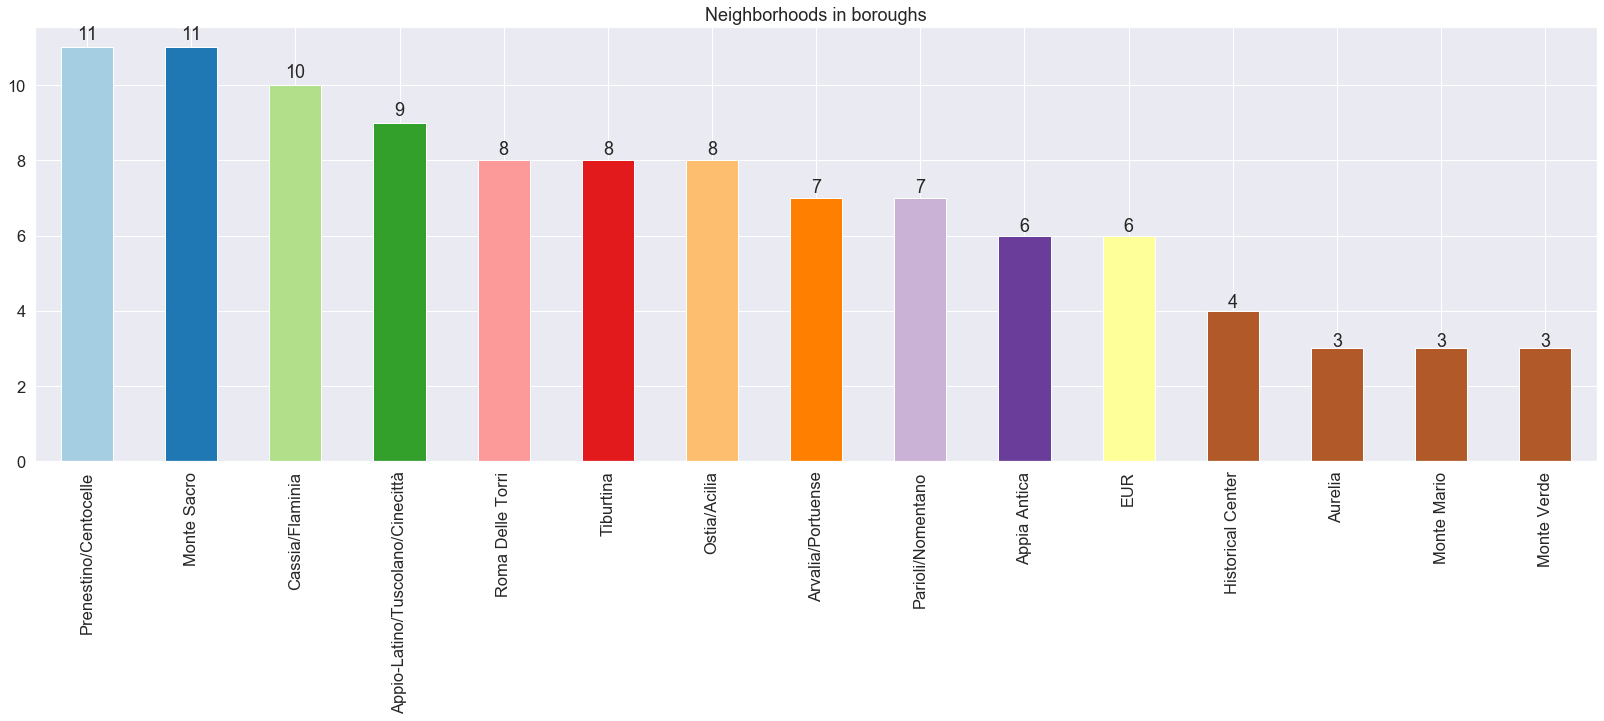

In [22]:
df_temp = italy_df.Borough.value_counts().to_frame()
bars = df_temp.plot(kind="bar", legend=False,
                    figsize=(28, 8),
                    title="Neighborhoods in boroughs",
                    color=[plt.cm.Paired(np.arange(len(df_temp)))])

for bar in bars.patches:
    width, height = bar.get_width(), bar.get_height()
    x, y = bar.get_xy() 
    bars.annotate(height, (x + width/2, y + height*1.02), ha='center')

Save the retrieved data to csv file, so you don't have to use the API everytime you run the notebook.

In [23]:
if not os.path.isfile("csv/rome_lon_lan.csv"):
    italy_df.to_csv("csv/rome_lon_lan.csv", index=False)

## Foursquare API
### Oslo, NORWAY
Retrieve the details about venues.

In [24]:
if os.path.isfile("csv/oslo_data_venues.csv"):
    oslo_data_venues = pd.read_csv("csv/oslo_data_venues.csv")
else:
    oslo_data_venues = get_close_venues(names=oslo_df['Neighborhood'],
                                   latitudes=oslo_df['Latitude'],
                                   longitudes=oslo_df['Longitude'],
                                   CLIENT_ID=CLIENT_ID,
                                   CLIENT_SECRET=CLIENT_SECRET
                                  )
    oslo_data_venues.to_csv("csv/oslo_data_venues.csv", index=False)
oslo_data_venues.shape

(947, 7)

Found venues per neighbourhood.

In [25]:
oslo_data_venues.groupby('Neighborhood').count()[["Venue"]]

,Venue
Neighborhood,
Alnabru,3
Ammerud,6
Bekkelaget,4
Berg,4
Bestum,4
...,...
Vækerø,5
Årvoll,13
Økern,8


One-hoting tables, so it will be easier to convert it into frequency later.

In [26]:
oslo_onehot = df_to_oneshot(oslo_data_venues)
oslo_onehot.head()

,Neighborhood,Advertising Agency,American Restaurant,Amphitheater,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Workshop,Bakery,...,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Warehouse Store,Water Park,Wine Bar,Wine Shop,Yoga Studio
0,Alnabru,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alnabru,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alnabru,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ellingsrud,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ellingsrud,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
oslo_classified_categories, df_facilities = classify_categories(oslo_onehot)
df_facilities

,Facility,Amount
0,gastronomy,55
1,entertainment,7
2,culture,13
3,tourists,18
4,sport,33
5,shops,44
6,other,7


In [28]:
oslo_categories_map = visualize_categories(OSLO_COORDS, oslo_data_venues, oslo_classified_categories)
oslo_categories_map

In [29]:
oslo_grouped = places_by_frequency(oslo_onehot)

In [30]:
oslo_venues_sorted = return_dataframe_most_common_venues(oslo_grouped)
oslo_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Alnabru,Bus Station,Paper / Office Supplies Store,Convenience Store,Food & Drink Shop,Food,Flower Shop
1,Ammerud,Metro Station,Grocery Store,Athletics & Sports,Supermarket,Soccer Field,Department Store
2,Bekkelaget,Gas Station,Light Rail Station,Bakery,Pizza Place,Yoga Studio,Electronics Store
3,Berg,Metro Station,Shopping Mall,Grocery Store,Flower Shop,Fish Market,Fast Food Restaurant
4,Bestum,Light Rail Station,Burger Joint,Bus Station,Yoga Studio,Electronics Store,Food
...,...,...,...,...,...,...,...
77,Vækerø,Moving Target,Burger Joint,Bus Station,Beach,Yoga Studio,Farmers Market
78,Årvoll,Supermarket,Chinese Restaurant,Grocery Store,Convenience Store,Farm,Bus Station
79,Økern,Convenience Store,Auto Workshop,Park,Bus Stop,Sushi Restaurant,Metro Station
80,Øraker,Soccer Field,Hockey Field,Athletics & Sports,Light Rail Station,Grocery Store,Metro Station


## Clustering Oslo

In [31]:
oslo_merged = cluster_venues(8, oslo_grouped, oslo_venues_sorted, oslo_df)
oslo_merged.head(13)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Alna,Alnabru,59.926682,10.836498,3,Bus Station,Paper / Office Supplies Store,Convenience Store,Food & Drink Shop,Food,Flower Shop
1,Alna,Ellingsrud,59.934191,10.920897,1,Metro Station,Warehouse Store,Gym / Fitness Center,Bed & Breakfast,Grocery Store,Yoga Studio
2,Alna,Furuset,59.941067,10.896399,0,Shopping Mall,Metro Station,Hockey Arena,Supermarket,Flower Shop,Fish Market
3,Alna,Haugerud,59.922116,10.854522,7,Gym,Metro Station,Grocery Store,Flower Shop,Fish Market,Fast Food Restaurant
4,Alna,Hellerud,59.910067,10.829839,5,Moving Target,Metro Station,Yoga Studio,Farm,Food & Drink Shop,Food
5,Alna,Lindeberg,59.933155,10.882706,7,Grocery Store,Furniture / Home Store,Motorcycle Shop,Metro Station,Food,Flower Shop
6,Alna,Trosterud,59.927182,10.865258,2,Furniture / Home Store,Hotel,Construction & Landscaping,Grocery Store,Fast Food Restaurant,Café
7,Alna,Tveita,59.914031,10.842241,2,Grocery Store,Metro Station,Convenience Store,Video Game Store,Supermarket,Bus Stop
8,Bjerke,Linderud,59.940963,10.838420,2,Wine Shop,Bakery,Fast Food Restaurant,Café,Grocery Store,Gym / Fitness Center
9,Bjerke,Tonsenhagen,59.947696,10.827078,1,Trail,Bus Station,Pool,Grocery Store,Yoga Studio,Flower Shop


In [96]:
# show_most_common_venue_count(oslo_merged)

In [33]:
import matplotlib.cm as cm
import matplotlib.colors as colors

oslo_map = show_map_clusters(8, oslo_merged, OSLO_COORDS)
oslo_map

### FIRST CLUSTER:
- Mostly shopping district
- Many shops and stores
- Few hotels

In [34]:
show_cluster_number(oslo_merged, 0)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
2,Furuset,Shopping Mall,Metro Station,Hockey Arena,Supermarket,Flower Shop,Fish Market
30,Ammerud,Metro Station,Grocery Store,Athletics & Sports,Supermarket,Soccer Field,Department Store
42,Tåsen,Metro Station,Shopping Mall,Grocery Store,Flower Shop,Fish Market,Fast Food Restaurant
44,Berg,Metro Station,Shopping Mall,Grocery Store,Flower Shop,Fish Market,Fast Food Restaurant
61,Mortensrud,Shopping Mall,Grocery Store,Metro Station,Convenience Store,Bus Station,Flower Shop
73,Ullernåsen,Trail,Hotel,Bus Station,Metro Station,Electronics Store,Food
74,Montebello,Metro Station,Hotel,Yoga Studio,Food,Flower Shop,Fish Market


### SECOND CLUSTER:
- Kind of sporty
- Smaller shops, like grocery stores
- Some restaurants

In [35]:
show_cluster_number(oslo_merged, 1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
1,Ellingsrud,Metro Station,Warehouse Store,Gym / Fitness Center,Bed & Breakfast,Grocery Store,Yoga Studio
9,Tonsenhagen,Trail,Bus Station,Pool,Grocery Store,Yoga Studio,Flower Shop
10,Årvoll,Supermarket,Chinese Restaurant,Grocery Store,Convenience Store,Farm,Bus Station
11,Veitvet,Bowling Alley,Shopping Mall,Soccer Field,Supermarket,Flower Shop,Fish Market
14,Bygdøy,Amphitheater,Athletics & Sports,History Museum,Farm,Yoga Studio,Electronics Store
21,Etterstad,Park,Grocery Store,Garden,Bus Station,Food,Flower Shop
29,Grorud,Grocery Store,Convenience Store,Pizza Place,Supermarket,Bus Station,Soccer Field
31,Grorud,Grocery Store,Convenience Store,Pizza Place,Supermarket,Bus Station,Soccer Field
32,Kalbakken,Grocery Store,Athletics & Sports,Indian Restaurant,Kebab Restaurant,Asian Restaurant,Shopping Mall
33,Rødtvet,Grocery Store,Indian Restaurant,Metro Station,Kebab Restaurant,Athletics & Sports,Pizza Place


### THIRD CLUSTER:
- Touristic district
- Hotels
- Bakeries, cafes, restaurants

In [36]:
show_cluster_number(oslo_merged, 2)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
6,Trosterud,Furniture / Home Store,Hotel,Construction & Landscaping,Grocery Store,Fast Food Restaurant,Café
7,Tveita,Grocery Store,Metro Station,Convenience Store,Video Game Store,Supermarket,Bus Stop
8,Linderud,Wine Shop,Bakery,Fast Food Restaurant,Café,Grocery Store,Gym / Fitness Center
12,Økern,Convenience Store,Auto Workshop,Park,Bus Stop,Sushi Restaurant,Metro Station
15,Frogner,Italian Restaurant,Café,Sculpture Garden,Scandinavian Restaurant,Gourmet Shop,Plaza
16,Majorstuen,Café,Bakery,Coffee Shop,Pub,Pizza Place,Bar
17,Uranienborg,Coffee Shop,Thai Restaurant,Pizza Place,Hotel,Café,Clothing Store
18,Ekebergskråningen,Dog Run,Boat or Ferry,Public Art,Burger Joint,Scenic Lookout,Port
19,Enerhaugen,Bar,Coffee Shop,Café,Indian Restaurant,Park,Sushi Restaurant
20,Ensjø,Gym / Fitness Center,Grocery Store,Convenience Store,Gastropub,Hockey Arena,Rental Car Location


### FOURTH CLUSTER:
- District for working people
- Can consider opening a store or restaurant here

In [37]:
show_cluster_number(oslo_merged, 3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Alnabru,Bus Station,Paper / Office Supplies Store,Convenience Store,Food & Drink Shop,Food,Flower Shop
37,Gaustad,Bus Station,Snack Place,Garden Center,Metro Station,Yoga Studio,Farm
41,Korsvoll,Bus Station,Soccer Field,Yoga Studio,Food & Drink Shop,Flower Shop,Fish Market
47,Frysja,Bus Station,Bathing Area,Grocery Store,Yoga Studio,Food,Flower Shop
80,"Smestad, Oslo",Bus Station,Restaurant,Bowling Alley,Creperie,Farm,Food


### FIFTH CLUSTER:
- Districts for people to stay
- Should consider opening a supermarket

In [38]:
show_cluster_number(oslo_merged, 4)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
70,Bestum,Light Rail Station,Burger Joint,Bus Station,Yoga Studio,Electronics Store,Food
71,Ullern,Light Rail Station,Flower Shop,Bus Station,Yoga Studio,Electronics Store,Food


### SIXTH CLUSTER:
- Entertainment districts
- Should consider opening a restaurant

In [39]:
show_cluster_number(oslo_merged, 5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
4,Hellerud,Moving Target,Metro Station,Yoga Studio,Farm,Food & Drink Shop,Food
69,Vækerø,Moving Target,Burger Joint,Bus Station,Beach,Yoga Studio,Farmers Market


### SEVENTH CLUSTER:
- Sporty and cultural districts
- Looks like family friendly area
- Should consider opening a supermarket

In [40]:
show_cluster_number(oslo_merged, 6)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
50,Nordstrand,Beach,Yoga Studio,French Restaurant,Food & Drink Shop,Food,Flower Shop
53,Ljan,Art Gallery,Train Station,Beach,Yoga Studio,Electronics Store,Food & Drink Shop


### EIGHTH CLUSTER:
- Tourist district
- Many grocery stores
- Should consider opening a gym

In [41]:
show_cluster_number(oslo_merged, 7)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
3,Haugerud,Gym,Metro Station,Grocery Store,Flower Shop,Fish Market,Fast Food Restaurant
5,Lindeberg,Grocery Store,Furniture / Home Store,Motorcycle Shop,Metro Station,Food,Flower Shop
13,Risløkka,Grocery Store,Hotel,Market,Nature Preserve,Metro Station,Hotel Bar
40,Kringsjå,Grocery Store,Metro Station,Bus Station,Lake,Yoga Studio,Food
65,Lysejordet,Convenience Store,Grocery Store,Food Truck,Food,Flower Shop,Fish Market


# Clustering Rome

In [42]:
if os.path.isfile("csv/rome_data_venues.csv"):
    rome_data_venues = pd.read_csv("csv/rome_data_venues.csv")
else:
    rome_data_venues = get_close_venues(names=italy_df['Neighborhood'],
                                   latitudes=italy_df['Latitude'],
                                   longitudes=italy_df['Longitude'],
                                   CLIENT_ID=CLIENT_ID,
                                   CLIENT_SECRET=CLIENT_SECRET
                                  )
    rome_data_venues.to_csv("csv/rome_data_venues.csv", index=False)
rome_data_venues.shape

(1339, 7)

In [43]:
rome_data_venues.groupby('Neighborhood').count()[["Venue"]]

,Venue
Neighborhood,
Acilia Nord,4
Acilia Sud,14
Acqua Vergine,80
Alessandrina,12
Appio-Claudio,23
...,...
Villa Ada,4
Villa Borghese,17
Villa Pamphili,5


In [44]:
rome_onehot = df_to_oneshot(rome_data_venues)
rome_onehot.head()

,Neighborhood,Abruzzo Restaurant,Accessories Store,Adult Boutique,Airport Service,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo
0,Trastevere,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Trastevere,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Trastevere,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Trastevere,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Trastevere,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
rome_classified_categories, df_facilities = classify_categories(rome_onehot)
df_facilities

,Facility,Amount
0,gastronomy,76
1,entertainment,16
2,culture,23
3,tourists,15
4,sport,29
5,shops,52
6,other,6


In [46]:
rome_categories_map = visualize_categories(ROME_COORDS, rome_data_venues, rome_classified_categories)
rome_categories_map

In [77]:
rome_grouped = places_by_frequency(rome_onehot)

In [84]:
rome_venues_sorted = return_dataframe_most_common_venues(rome_grouped)
rome_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Acilia Nord,Café,Bakery,Sushi Restaurant,Chinese Restaurant,Food,Flower Shop
1,Acilia Sud,Plaza,Café,Bakery,Steakhouse,Ice Cream Shop,Pizza Place
2,Acqua Vergine,Italian Restaurant,Ice Cream Shop,Plaza,Hotel,Bistro,Café
3,Alessandrina,Bakery,Plaza,Art Gallery,Theater,Trattoria/Osteria,Coffee Shop
4,Appio-Claudio,Pizza Place,Café,Clothing Store,Pub,Ice Cream Shop,Fast Food Restaurant
...,...,...,...,...,...,...,...
94,Villa Ada,Music Venue,Beer Garden,Lake,Park,Zoo,Ethiopian Restaurant
95,Villa Borghese,Movie Theater,Dog Run,Snack Place,Plaza,Fountain,Garden
96,Villa Pamphili,Bookstore,Hotel,Pool Hall,Spa,Paper / Office Supplies Store,Ethiopian Restaurant
97,Villaggio Olimpico,Bookstore,Auditorium,Music Venue,Seafood Restaurant,Sandwich Place,Supermarket


In [85]:
rome_merged = cluster_venues(7, rome_grouped, rome_venues_sorted, italy_df)
rome_merged.head(13)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Historical Center,Trastevere,41.883765,12.471270,2.0,Italian Restaurant,Pizza Place,Ice Cream Shop,Café,Plaza,Theater
1,Historical Center,Aventino,41.882825,12.486819,2.0,Italian Restaurant,Restaurant,Café,Gastropub,Track Stadium,Scenic Lookout
2,Historical Center,Esquilino,41.898044,12.498863,2.0,Hotel,Italian Restaurant,Café,Pizza Place,Bed & Breakfast,Plaza
3,Historical Center,XX Settembre,41.906151,12.496895,2.0,Italian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Restaurant,Hostel
4,Parioli/Nomentano,Villaggio Olimpico,41.932966,12.474157,2.0,Bookstore,Auditorium,Music Venue,Seafood Restaurant,Sandwich Place,Supermarket
5,Parioli/Nomentano,Parioli,41.925949,12.487321,2.0,Italian Restaurant,Café,Seafood Restaurant,Pizza Place,Sandwich Place,Hotel
6,Parioli/Nomentano,Flaminio,41.912829,12.477139,2.0,Italian Restaurant,Hotel,Plaza,Restaurant,Ice Cream Shop,Pizza Place
7,Parioli/Nomentano,Salario,41.922978,12.502636,2.0,Italian Restaurant,Hotel,Cocktail Bar,Seafood Restaurant,Café,Restaurant
8,Parioli/Nomentano,Villa Borghese,41.914324,12.483789,0.0,Movie Theater,Dog Run,Snack Place,Plaza,Fountain,Garden
9,Parioli/Nomentano,Villa Ada,41.931603,12.502293,0.0,Music Venue,Beer Garden,Lake,Park,Zoo,Ethiopian Restaurant


In [95]:
# show_most_common_venue_count(rome_merged)

In [87]:
rome_map = show_map_clusters(7, rome_merged, ROME_COORDS)
rome_map

### FIRST CLUSTER:
- Cultural activities
- Parks, Plazas, Zoos
- Can consider opening a cafe here

In [88]:
show_cluster_number(rome_merged, 0)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
8,Villa Borghese,Movie Theater,Dog Run,Snack Place,Plaza,Fountain,Garden
9,Villa Ada,Music Venue,Beer Garden,Lake,Park,Zoo,Ethiopian Restaurant
14,Serpentara,Park,Café,Cocktail Bar,Butcher,Zoo,Flower Shop
18,Tufello,Café,Plaza,Park,Train Station,Bakery,Zoo
34,Centocelle,Light Rail Station,Pizza Place,Department Store,Italian Restaurant,Metro Station,Supermarket
35,Alessandrina,Bakery,Plaza,Art Gallery,Theater,Trattoria/Osteria,Coffee Shop
38,Tor Tre Teste,Ice Cream Shop,Supermarket,Athletics & Sports,Park,Zoo,Ethiopian Restaurant
39,Casetta Mistica,Bakery,Betting Shop,Pizza Place,Dessert Shop,Zoo,Food
46,Torre Angela,Cupcake Shop,Arepa Restaurant,Hookah Bar,Pizza Place,Park,Grocery Store
49,Tor Fiscale,Restaurant,Golf Course,Bus Station,Park,Zoo,Ethiopian Restaurant


### SECOND CLUSTER:
- Mostly Italian Restaurant here
- Many food buildings
- Supermarkets and stores

In [89]:
show_cluster_number(rome_merged, 1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
13,Fidene,Italian Restaurant,Grocery Store,Zoo,Electronics Store,Food,Flower Shop
24,Tiburtino Nord,Italian Restaurant,Ice Cream Shop,Dessert Shop,Ethiopian Restaurant,Food Truck,Food
29,Settecamini,Italian Restaurant,Café,Plaza,Cocktail Bar,Zoo,Food
65,Mezzocammino,Italian Restaurant,Flower Shop,Park,Café,Gym / Fitness Center,Zoo
70,Malafede,Italian Restaurant,Supermarket,Park,Zoo,Electronics Store,Flower Shop
75,Castel Fusano,Italian Restaurant,Food Truck,Furniture / Home Store,Electronics Store,Food,Flower Shop
76,Infernetto,Italian Restaurant,Golf Course,Zoo,Electronics Store,Food,Flower Shop
93,Santa Maria di Galeria,Italian Restaurant,Zoo,Electronics Store,Food,Flower Shop,Flea Market
94,Tor di Quinto,Italian Restaurant,Light Rail Station,Zoo,Ethiopian Restaurant,Food Truck,Food


### THIRD CLUSTER:
- Hotels and restaurant
- Some food places
- Looks like an area for busy people

In [90]:
show_cluster_number(rome_merged, 2)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Trastevere,Italian Restaurant,Pizza Place,Ice Cream Shop,Café,Plaza,Theater
1,Aventino,Italian Restaurant,Restaurant,Café,Gastropub,Track Stadium,Scenic Lookout
2,Esquilino,Hotel,Italian Restaurant,Café,Pizza Place,Bed & Breakfast,Plaza
3,XX Settembre,Italian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Restaurant,Hostel
4,Villaggio Olimpico,Bookstore,Auditorium,Music Venue,Seafood Restaurant,Sandwich Place,Supermarket
...,...,...,...,...,...,...,...
92,Trionfale,Supermarket,Pizza Place,Italian Restaurant,Chinese Restaurant,Gym,Gym / Fitness Center
96,Tomba di Nerone,Café,Movie Theater,Pizza Place,Italian Restaurant,Brewery,Supermarket
97,Giustiniana,Ice Cream Shop,Supermarket,Health Food Store,Electronics Store,Donut Shop,Flower Shop
100,Prima Porta,Adult Boutique,Light Rail Station,Gym / Fitness Center,Electronics Store,Zoo,Ethiopian Restaurant


### FOURTH CLUSTER:
- Directed at women
- Can consider opening a cafe or some store here

In [91]:
show_cluster_number(rome_merged, 3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
45,Lunghezza,Women's Store,Zoo,Electronics Store,Food,Flower Shop,Flea Market


### FIFTH CLUSTER:
- Directed at women
- Can consider opening a cafe here

In [92]:
show_cluster_number(rome_merged, 4)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
20,Bufalotta,Spa,Zoo,Construction & Landscaping,Food,Flower Shop,Flea Market


### SIXTH CLUSTER:
- Hotels and restaurant
- Few places for entertainment, but not many
- Few sport places
- Looks like neighborhoods for ordinary working people
- Can consider opening a supermarket here

In [93]:
show_cluster_number(rome_merged, 5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
21,Tor San Giovanni,Restaurant,Zoo,Electronics Store,Food,Flower Shop,Flea Market
26,Tor Cervara,Café,Gym / Fitness Center,Hotel,Restaurant,Historic Site,Donut Shop
36,Tor Sapienza,Hotel,Restaurant,Supermarket,Train Station,Café,Zoo
37,La Rustica,Hotel,Restaurant,Clothing Store,Shopping Mall,Train Station,Zoo
67,Vallerano-Castel di Leva,Hotel,Stadium,Restaurant,Soccer Field,Food,Zoo
68,Santa Palomba,Restaurant,Train Station,Construction & Landscaping,Courthouse,Cupcake Shop,Food
73,Palocco,Gym / Fitness Center,Gym,Restaurant,Massage Studio,Flower Shop,Flea Market
74,Ostia Antica,Boat or Ferry,Café,Restaurant,Coffee Shop,Food,Flower Shop
99,Santa Cornelia,Restaurant,Construction & Landscaping,Zoo,Electronics Store,Food,Flower Shop
102,Cesano,Train Station,Playground,Donut Shop,Food,Flower Shop,Flea Market


### SEVENTH CLUSTER:
- Cafe district
- Looks like family friendly area
- Should consider opening some store or supermarket

In [94]:
show_cluster_number(rome_merged, 6)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
19,Settebagni,Café,Train Station,Italian Restaurant,Electronics Store,Food,Flower Shop
47,Borghesiana,Italian Restaurant,Bar,Café,Zoo,Ethiopian Restaurant,Food
63,Grottaperfetta,Café,Gym,Pub,Courthouse,Cupcake Shop,Food
98,La Storta,Café,Deli / Bodega,Burger Joint,Bakery,Zoo,Food Truck
101,Labaro,Café,Italian Restaurant,Pizza Place,Zoo,Food,Flower Shop


# Final thoughts:
The South capital, Rome seems to have more restaurants, cafes, and food-related places. On the other hand, there aren't many sport-related places, like gyms. What's surprising, looks like there aren't many cultural places like galleries, libraries, etc. either.

Oslo consists of myriads of stores and shops. There are also many restaurant, cultural, and sport-related places. On the other hand, there aren't many hotels or entertainment places.